<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/bert%26LSTM_AGnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import sklearn
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [2]:
# 分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [4]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['readme.txt', 'classes.txt', 'test.csv', 'train.csv']

In [5]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
num = 3400
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

3400
       0  ...                                                  2
89907  4  ...  On 9 November 2004, the FCC declared that VoIP...
24749  2  ...  Derrek Lee whacked a three-run double against ...
4776   4  ...  The controversial Eolas Technologies patent lo...
80559  1  ...  The United States will not change their policy...
88695  2  ...  Tracy McGrady had 17 points, including the win...

[5 rows x 3 columns]
3400
      0  ...                                                  2
6255  1  ...  International Atomic Energy Agency (IAEA) Dire...
7279  2  ...  One of the three women suing the University of...
2814  1  ...  Australian Prime Minister John Howard said Thu...
2249  1  ...  Los Angeles Times - BAGHDAD  #8212; Militants ...
516   1  ...  AP - British Foreign Secretary Jack Straw, tou...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [7]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [8]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101  2006  1023  2281  2432  1010  1996 14420  4161  2008 29536 11514
  2578  2107  2004  3854  4270  9583  1001  4464  1025  3617  6767  6610
  2024  2025  3395  2000  3151  2110  2270  9710  7816  1010  1998  2008
  1996 14420  2894  2038  7360  2182  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [9]:
# 训练参数
epochs = 1
batch_size = 16
validation_rate = 0.1

In [10]:
# 模型放在这里
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4, output_hidden_states=True) # 分类类别数
model.summary()
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [11]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 768),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 768)         23440896  
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              5246976   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 28,951,300
Trainable params: 28,951,300
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_compare.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
# history是按照一个epoch记录一次，间隔太大了，所以手动重写一个基于batch的
class BatchCallback(tf.keras.callbacks.History):
  def __init__(self):
    self.batch = []
    self.history = {'loss':[], 'accuracy':[]}
  def on_train_batch_end(self, batch, logs=None):
    self.batch.append(batch)
    for k, v in logs.items():
      self.history[k].append(v)

In [14]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

213/213 [==============================] - 108s 506ms/step - loss: 0.5019 - accuracy: 0.8324


In [15]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=[BatchCallback()],
    shuffle=True
)

213/213 [==============================] - 59s 275ms/step - loss: 1.3170 - accuracy: 0.6116


In [16]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

213/213 [==============================] - 37s 175ms/step - loss: 0.3468 - accuracy: 0.8835


[0.3467797040939331, 0.8835294246673584]

In [17]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

213/213 [==============================] - 7s 31ms/step - loss: 1.0885 - accuracy: 0.5053


[1.0884841680526733, 0.505294144153595]

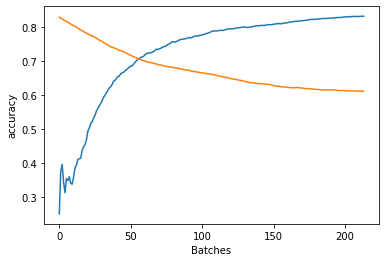

In [18]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [19]:
index = None
for idx, layer in enumerate(model_compare.layers):
  print(idx, layer.name)

0 embedding
1 bidirectional
2 dense
3 dense_1


In [20]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
# 用index更好
embedding_compare = model_compare.get_layer(index=0)

In [21]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = embedding_compare(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
  embs_list.append(embs)
embs = embedding_compare(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
embs_list.append(embs)
seq_embs_compare = tf.concat(embs_list, 0)
class_embedding_compare = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs_compare[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding_compare)

[[-0.00836811  0.00197056  0.0221793  ... -0.02961254  0.00983892
  -0.01342478]
 [-0.00837806  0.00194991  0.0217973  ... -0.02981011  0.00957122
  -0.01337816]
 [-0.00828522  0.0022501   0.02140683 ... -0.02933873  0.00924416
  -0.01351447]
 [-0.00862434  0.00216709  0.02174062 ... -0.0296837   0.00950773
  -0.01351629]]


In [22]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [23]:
# 得到每个类的embedding
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = get_embedding(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
  embs_list.append(embs)
embs = get_embedding(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
embs_list.append(embs)
seq_embs = tf.concat(embs_list, 0)
print(seq_embs)
class_embedding = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding)

tf.Tensor(
[[-0.01207865 -0.05306159 -0.02565962 ... -0.01915377 -0.03290265
  -0.00809146]
 [-0.00948817 -0.05444287 -0.02402405 ... -0.02038081 -0.03302491
  -0.00918202]
 [-0.01139881 -0.0535837  -0.02454424 ... -0.01869218 -0.03105265
  -0.00765832]
 ...
 [-0.01138106 -0.05455643 -0.02551769 ... -0.01878718 -0.03225908
  -0.00959148]
 [-0.01238753 -0.0499268  -0.02351259 ... -0.01763974 -0.03072252
  -0.00808018]
 [-0.01163121 -0.05206889 -0.02332763 ... -0.01721448 -0.03235023
  -0.01014471]], shape=(3400, 768), dtype=float32)
[[-0.01134278 -0.05426445 -0.02493972 ... -0.0191326  -0.03381954
  -0.00941559]
 [-0.01121927 -0.05429773 -0.02456746 ... -0.01927376 -0.03374501
  -0.00947428]
 [-0.01133097 -0.05459631 -0.0250778  ... -0.01885808 -0.03263801
  -0.0091032 ]
 [-0.01138156 -0.05447564 -0.0250102  ... -0.01871866 -0.03291832
  -0.00923214]]


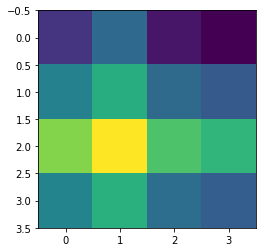

In [24]:
# 类表征的余弦相似性
res = sklearn.metrics.pairwise.cosine_similarity(class_embedding, class_embedding_compare)
plt.imshow(res)
plt.show()

In [25]:
# t-SNE分析
